# **Modeling and Evaluation Notebook**

## Objectives

- Answer Business Requirement 2: train regression models to predict house sale prices
- Fit and evaluate a regression model to predict the sale price of a house

## Inputs

- outputs/datasets/cleaned/HousePricesCleaned.csv
- Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

- Train set (features and target)
- Test set (features and target)
- ML pipeline to predict sale price
- Feature importance plot



---

# Change working directory

In [1]:
import os

# set project root
dir_path = os.getcwd()
os.chdir(os.path.dirname(dir_path))
print("Working dir:", os.getcwd())

Working dir: /workspaces/heritage-housing


## Load Feature Engineered Datasets

In [2]:
import pandas as pd

# Load Train Set
train_path = "outputs/datasets/feature_engineered/Train_FE.csv"
train_df = pd.read_csv(train_path)

# Load Test Set
test_path = "outputs/datasets/feature_engineered/Test_FE.csv"
test_df = pd.read_csv(test_path)

# Split features and target
X_train = train_df.drop("SalePrice", axis=1)
y_train = train_df["SalePrice"]

X_test = test_df.drop("SalePrice", axis=1)
y_test = test_df["SalePrice"]

print("* Train set:", X_train.shape, y_train.shape)
print("* Test set:", X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,)
* Test set: (292, 21) (292,)


---

## Import Libraries and Suppress Warnings

In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor,
)
from sklearn.linear_model import LinearRegression


### Load feature engineered datasets

In [4]:

X_train = pd.read_csv("outputs/datasets/feature_engineered/Train_FE.csv").drop(
    "SalePrice", axis=1
)
y_train = pd.read_csv("outputs/datasets/feature_engineered/Train_FE.csv")["SalePrice"]

X_test = pd.read_csv("outputs/datasets/feature_engineered/Test_FE.csv").drop(
    "SalePrice", axis=1
)
y_test = pd.read_csv("outputs/datasets/feature_engineered/Test_FE.csv")["SalePrice"]

Custom Class for Hyperparameter Optimization from Code Institute:

In [5]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineRgr(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(
                model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring
            )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by="mean_score"):
        def row(key, scores, params):
            d = {
                "estimator": key,
                "min_score": min(scores),
                "max_score": max(scores),
                "mean_score": np.mean(scores),
                "std_score": np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_["params"]
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ["estimator", "min_score", "mean_score", "max_score", "std_score"]
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

In [6]:
def PipelineRgr(model):
    pipeline_base = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("feat_selection", SelectFromModel(model)),
            ("model", model),
        ]
    )
    return pipeline_base

---

## Grid Search CV - SKlearn

Use standard hyperparameters to find most suitable algorithm

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models_quick_search = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_quick_search = {
    "LinearRegression": {},  

    "RandomForestRegressor": {
        "model__n_estimators": [50, 100],        
        "model__max_depth": [None, 10],          
    },

    "GradientBoostingRegressor": {
        "model__n_estimators": [50, 100],
        "model__learning_rate": [0.1],
        "model__max_depth": [3, 5],
    },
}


Quick GridSearch CV - Regression

In [8]:
search = HyperparameterOptimizationSearch(
    models=models_quick_search,
    params=params_quick_search
)

search.fit(X_train, y_train, scoring="r2", n_jobs=1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [9]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by="mean_score")
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators,model__learning_rate
0,LinearRegression,0.732024,0.788529,0.829753,0.034429,NaN,NaN,NaN
7,GradientBoostingRegressor,0.648785,0.78309,0.831872,0.067885,5,50,0.1
5,GradientBoostingRegressor,0.656227,0.779601,0.831401,0.063054,3,50,0.1
8,GradientBoostingRegressor,0.633948,0.774614,0.819945,0.070775,5,100,0.1
6,GradientBoostingRegressor,0.624589,0.76683,0.820709,0.07241,3,100,0.1
4,RandomForestRegressor,0.702972,0.756645,0.82262,0.047703,10,100,NaN
3,RandomForestRegressor,0.706348,0.751655,0.820981,0.048758,10,50,NaN
2,RandomForestRegressor,0.673179,0.744514,0.816369,0.05427,None,100,NaN
1,RandomForestRegressor,0.676389,0.7399,0.817066,0.055818,None,50,NaN


### Retrain Best Estimator (GradientBoostingRegressor) with Selected Parameters

In [11]:
# Retrain the best estimator using the selected parameters for GradientBoostingRegressor

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Define the model with the best parameters from GridSearchCV
best_model = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=50,
    random_state=0
)

# Build the final pipeline (scaling + model)
best_regressor_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", best_model),
])

# Fit the pipeline on the full training data
best_regressor_pipeline.fit(X_train, y_train)

# Make sure the output directory exists
version = "v1"
file_path = f"outputs/ml_pipeline/predict_sale_price/{version}"
os.makedirs(file_path, exist_ok=True)

# Save the trained pipeline for later use
joblib.dump(best_regressor_pipeline, f"{file_path}/best_regressor_pipeline.pkl")



['outputs/ml_pipeline/predict_sale_price/v1/best_regressor_pipeline.pkl']

#### Do an extensive search on the most suitable algorithm, ie GradientBoosterRegressor, to find the best hyperparameter configuration.

In [12]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor": {
        "model__n_estimators": [50, 100, 150],
        "model__max_depth": [None, 3, 15],
        "model__min_samples_split": [2, 50],
        "model__min_samples_leaf": [1, 50],
    },
}

Extensive GridSearch CV - Regression

In [13]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring="r2", n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Check results

In [14]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by="mean_score")
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
26,ExtraTreesRegressor,0.706523,0.82276,0.877453,0.061469,15,1,2,150
1,ExtraTreesRegressor,0.712474,0.820925,0.871529,0.058357,None,1,2,100
25,ExtraTreesRegressor,0.700125,0.820688,0.878437,0.063591,15,1,2,100
2,ExtraTreesRegressor,0.710257,0.820063,0.869849,0.058765,None,1,2,150
0,ExtraTreesRegressor,0.710842,0.81932,0.871588,0.058223,None,1,2,50
24,ExtraTreesRegressor,0.691983,0.817522,0.872828,0.064962,15,1,2,50
4,ExtraTreesRegressor,0.760802,0.816541,0.858713,0.042,None,1,50,100
28,ExtraTreesRegressor,0.760085,0.816396,0.858713,0.042192,15,1,50,100
5,ExtraTreesRegressor,0.759507,0.816066,0.859057,0.04251,None,1,50,150
29,ExtraTreesRegressor,0.759008,0.815982,0.859057,0.042627,15,1,50,150


In [15]:
# Retrain the best ExtraTreesRegressor model based on the best GridSearchCV parameters

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Set version and save path
version = "v2"  # 
file_path = f"outputs/ml_pipeline/predict_sale_price/{version}"
os.makedirs(file_path, exist_ok=True)

# Define the best model
best_model = ExtraTreesRegressor(
    n_estimators=150,
    max_depth=15,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=0,
)

# Build the final pipeline
best_regressor_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", best_model),
])

# Fit the pipeline
best_regressor_pipeline.fit(X_train, y_train)

# Save pipeline
joblib.dump(best_regressor_pipeline, f"{file_path}/best_regressor_pipeline.pkl")

print(f"Model trained and saved at: {file_path}")


Model trained and saved at: outputs/ml_pipeline/predict_sale_price/v2


Get best model name programmatically

In [16]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

Parameters for best model

In [17]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

## Assess Feature Importance

In [18]:
X_train.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
0,42.755117,0.0,3.0,0,6.928203,0,42.118879,774,0,2007.0,...,0,9.366831,9.486833,21.260292,10.392305,5,9,1822,2007,2007
1,29.899833,0.0,2.0,1,0.000000,0,29.899833,308,0,1962.0,...,1,8.794825,7.745967,0.000000,0.000000,5,5,894,1962,1962
2,31.048349,0.0,2.0,1,26.702060,1,12.767145,432,0,1921.0,...,1,9.500020,8.944272,0.000000,0.000000,7,5,876,1921,2006


* These are the 21 most important features:
['OverallQual', 'GrLivArea', 'YearBuilt', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearRemodAdd', 'KitchenQual', 'GarageYrBlt', 'BsmtFinSF1', 'LotArea', 'MasVnrArea', '2ndFlrSF', 'GarageFinish', 'OverallCond', 'LotFrontage', 'BedroomAbvGr', 'OpenPorchSF', 'BsmtUnfSF', 'BsmtExposure', 'BsmtFinType1']


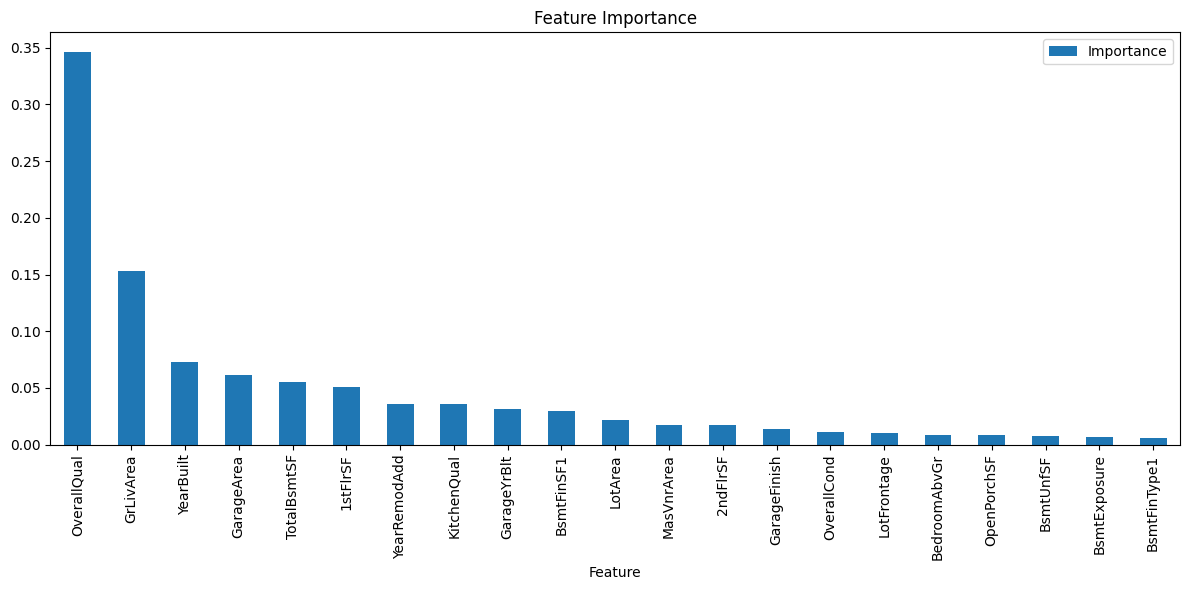

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature importance for GradientBoosting or other tree-based models
df_feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_regressor_pipeline["model"].feature_importances_
}).sort_values(by="Importance", ascending=False)

# Print top features
best_features = df_feature_importance["Feature"].tolist()
print(f"* These are the {len(best_features)} most important features:")
print(best_features)

# Plot
df_feature_importance.plot(kind="bar", x="Feature", y="Importance", figsize=(12, 6))
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


## Evaluate Pipeline on Train and Test Sets

Measure how close regression line is to data points with mean and absolute error

In [21]:
# MSE
from sklearn.metrics import mean_squared_error

y_pred_train = best_regressor_pipeline.predict(X_train)
print("Mean squared error (Train):", mean_squared_error(y_train, y_pred_train))

Mean squared error (Train): 1132388.3281790088


In [22]:
# MAE
from sklearn.metrics import mean_absolute_error

print("Mean absolute error (Train):", mean_absolute_error(y_train, y_pred_train))

Mean absolute error (Train): 675.2692724650389


In [23]:
# R²
from sklearn.metrics import r2_score

print("R² score (Train):", r2_score(y_train, y_pred_train))

R² score (Train): 0.9998160799658179


The R² score of 0.87+ is a very good score and indicates a good fit for our model.

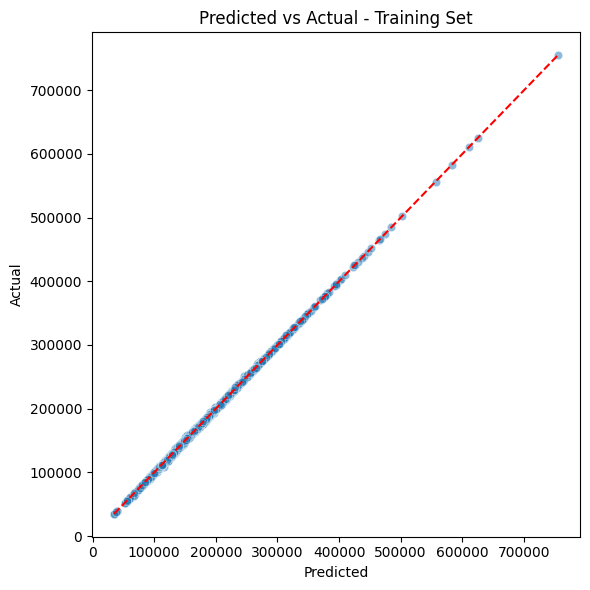

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_pred_train, y=y_train, alpha=0.5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Predicted vs Actual - Training Set")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.tight_layout()
plt.show()

## Rewrite Pipeline with the best parameters

In [25]:
best_features

['OverallQual',
 'GrLivArea',
 'YearBuilt',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'YearRemodAdd',
 'KitchenQual',
 'GarageYrBlt',
 'BsmtFinSF1',
 'LotArea',
 'MasVnrArea',
 '2ndFlrSF',
 'GarageFinish',
 'OverallCond',
 'LotFrontage',
 'BedroomAbvGr',
 'OpenPorchSF',
 'BsmtUnfSF',
 'BsmtExposure',
 'BsmtFinType1']

ML Pipeline for Modelling and Hyperparameter Optimization

In [26]:
def PipelineRgr(model):  # new def PipelineRgr
    pipeline_base = Pipeline(
        [
            ("scaler", StandardScaler()),
            # ("feat_selection", SelectFromModel(model)),
            ("model", model),
        ]
    )

    return pipeline_base

Update Train and Test Sets with best features

In [27]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(5)

(1168, 21) (1168,) (292, 21) (292,)


,OverallQual,GrLivArea,YearBuilt,GarageArea,TotalBsmtSF,1stFlrSF,YearRemodAdd,KitchenQual,GarageYrBlt,BsmtFinSF1,...,MasVnrArea,2ndFlrSF,GarageFinish,OverallCond,LotFrontage,BedroomAbvGr,OpenPorchSF,BsmtUnfSF,BsmtExposure,BsmtFinType1
0,9,7.510978,2007,774,1822,42.755117,2007,0,2007.0,6.928203,...,21.260292,0.0,0,5,9.486833,3.0,10.392305,42.118879,0,0
1,5,6.795706,1962,308,894,29.899833,1962,1,1962.0,0.000000,...,0.000000,0.0,0,5,7.745967,2.0,0.000000,29.899833,1,0
2,5,6.871091,1921,432,876,31.048349,2006,1,1921.0,26.702060,...,0.000000,0.0,0,7,8.944272,2.0,0.000000,12.767145,1,1
3,8,7.431892,2002,857,1568,41.097445,2002,0,2002.0,34.899857,...,12.165525,0.0,1,5,8.306624,3.0,7.681146,18.708287,1,2
4,7,7.340187,2001,843,1541,39.255573,2002,0,2001.0,0.000000,...,12.247449,0.0,1,5,10.601536,3.0,9.000000,39.255573,1,0


In [28]:
best_model

'ExtraTreesRegressor'

In [29]:
best_parameters

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

Now we only apply the best parameters:

In [31]:
# ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor

models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor": {
        "model__max_depth": [15],
        "model__min_samples_leaf": [1],
        "model__min_samples_split": [2],
        "model__n_estimators": [150],
    }
}

Perform Grid Search with the best parameters

In [32]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring="r2", n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


View search results

In [33]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by="mean_score")
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.75015,0.859171,0.902254,0.056113,15,1,2,150


Confirm dataset shape

In [34]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(1168, 21) (1168,) (292, 21) (292,)


,OverallQual,GrLivArea,YearBuilt,GarageArea,TotalBsmtSF,1stFlrSF,YearRemodAdd,KitchenQual,GarageYrBlt,BsmtFinSF1,...,MasVnrArea,2ndFlrSF,GarageFinish,OverallCond,LotFrontage,BedroomAbvGr,OpenPorchSF,BsmtUnfSF,BsmtExposure,BsmtFinType1
0,9,7.510978,2007,774,1822,42.755117,2007,0,2007.0,6.928203,...,21.260292,0.0,0,5,9.486833,3.0,10.392305,42.118879,0,0
1,5,6.795706,1962,308,894,29.899833,1962,1,1962.0,0.000000,...,0.000000,0.0,0,5,7.745967,2.0,0.000000,29.899833,1,0
2,5,6.871091,1921,432,876,31.048349,2006,1,1921.0,26.702060,...,0.000000,0.0,0,7,8.944272,2.0,0.000000,12.767145,1,1


Extract the best estimator pipeline

In [35]:
best_model = grid_search_summary.iloc[0, 0]
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=15, n_estimators=150,
                                     random_state=0))])

## Retrain and Save Final ExtraTreesRegressor Pipeline with Best Parameters

In [36]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib
import os

# Final best model based on grid search results
best_model = ExtraTreesRegressor(
    max_depth=15,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=150,
    random_state=0
)

# Final pipeline with scaler and model
best_regressor_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", best_model),
])

# Fit pipeline to training data
best_regressor_pipeline.fit(X_train, y_train)

# Create output directory if it doesn't exist
output_dir = "outputs/ml_pipeline/predict_sale_price/v1"
os.makedirs(output_dir, exist_ok=True)

# Save the pipeline
joblib.dump(best_regressor_pipeline, f"{output_dir}/best_regressor_pipeline.pkl")


['outputs/ml_pipeline/predict_sale_price/v1/best_regressor_pipeline.pkl']

---

# Push files to Repo

The following files will be created and pushed to the repo:

- Train Set
- Test Set
- Modeling Pipeline
- Feature importance Plot

In [37]:
import joblib
import os

version = "v1"
file_path = f"outputs/ml_pipeline/predict_sale_price/{version}"

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_sale_price/v1'


## Train Set: Features And Target

In [38]:
print(X_train.shape)
X_train.head()

(1168, 21)


,OverallQual,GrLivArea,YearBuilt,GarageArea,TotalBsmtSF,1stFlrSF,YearRemodAdd,KitchenQual,GarageYrBlt,BsmtFinSF1,...,MasVnrArea,2ndFlrSF,GarageFinish,OverallCond,LotFrontage,BedroomAbvGr,OpenPorchSF,BsmtUnfSF,BsmtExposure,BsmtFinType1
0,9,7.510978,2007,774,1822,42.755117,2007,0,2007.0,6.928203,...,21.260292,0.0,0,5,9.486833,3.0,10.392305,42.118879,0,0
1,5,6.795706,1962,308,894,29.899833,1962,1,1962.0,0.000000,...,0.000000,0.0,0,5,7.745967,2.0,0.000000,29.899833,1,0
2,5,6.871091,1921,432,876,31.048349,2006,1,1921.0,26.702060,...,0.000000,0.0,0,7,8.944272,2.0,0.000000,12.767145,1,1
3,8,7.431892,2002,857,1568,41.097445,2002,0,2002.0,34.899857,...,12.165525,0.0,1,5,8.306624,3.0,7.681146,18.708287,1,2
4,7,7.340187,2001,843,1541,39.255573,2002,0,2001.0,0.000000,...,12.247449,0.0,1,5,10.601536,3.0,9.000000,39.255573,1,0


In [39]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [40]:
y_train.head()

0    314813
1    109500
2    163500
3    271000
4    205000
Name: SalePrice, dtype: int64

In [41]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: Features And Target

In [42]:
print(X_test.shape)
X_test.head()

(292, 21)


,OverallQual,GrLivArea,YearBuilt,GarageArea,TotalBsmtSF,1stFlrSF,YearRemodAdd,KitchenQual,GarageYrBlt,BsmtFinSF1,...,MasVnrArea,2ndFlrSF,GarageFinish,OverallCond,LotFrontage,BedroomAbvGr,OpenPorchSF,BsmtUnfSF,BsmtExposure,BsmtFinType1
0,6,7.830028,1957,484,2035,48.583403,1975,0,1975.0,34.914181,...,0.000000,0.000000,0,3,8.306624,4.0,0.000000,28.565714,0,0
1,6,7.363914,1941,240,806,30.951575,1950,1,1941.0,20.074860,...,0.000000,24.899799,0,7,8.888194,3.0,0.000000,15.427249,0,1
2,5,7.092574,1950,352,709,31.288976,1950,2,1950.0,13.601471,...,12.688578,14.966630,0,4,8.306624,3.0,0.000000,22.891046,0,2
3,7,7.611842,1977,505,1160,34.000000,1977,0,1977.0,19.798990,...,17.291616,29.427878,1,5,9.110434,4.0,10.816654,27.712813,0,1
4,6,6.995766,1971,264,525,22.912878,1971,0,1971.0,0.000000,...,19.519221,0.000000,0,5,6.032625,3.0,0.000000,22.912878,0,3


In [43]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [44]:
y_test.head()

0    200624
1    133000
2    110000
3    192000
4     88000
Name: SalePrice, dtype: int64

In [45]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Pipeline

In [46]:
best_regressor_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=15, n_estimators=150,
                                     random_state=0))])

In [47]:
joblib.dump(
    value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl"
)

['outputs/ml_pipeline/predict_sale_price/v1/best_regressor_pipeline.pkl']

## Feature Importance Plot

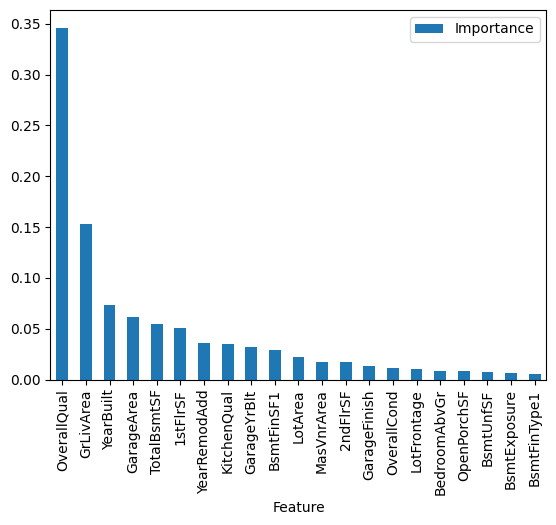

In [48]:
df_feature_importance.plot(kind="bar", x="Feature", y="Importance")
plt.show()

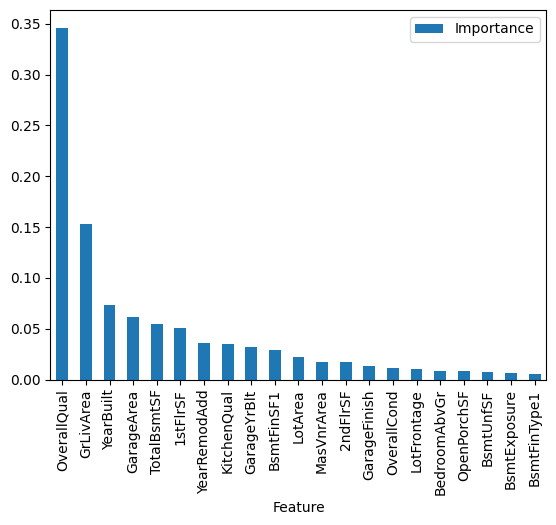

In [49]:
df_feature_importance.plot(kind="bar", x="Feature", y="Importance")
plt.savefig(f"{file_path}/feature_importance.png", bbox_inches="tight")

In [50]:
import os

print("Files saved to:", file_path)
print("Saved files:", os.listdir(file_path))

Files saved to: outputs/ml_pipeline/predict_sale_price/v1
Saved files: ['y_train.csv', 'X_test.csv', 'feature_importance.png', 'X_train.csv', 'y_test.csv', 'best_regressor_pipeline.pkl']


This completes the notebook.